<a href="https://colab.research.google.com/github/SEEsuite/colab_scripts/blob/main/get_segmentation_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure your colab environment has GPU enabled

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.7 MB/s eta 0:00:00


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.4 MB/s eta 0:00:00


In [26]:
import datasets
import pandas as pd

from datasets import load_dataset


from PIL import Image
import requests

### Load Segmentation model

[this](https://github.com/huggingface/notebooks/blob/main/examples/automatic_mask_generation.ipynb) notebook seems to have the easiest usage of S.A.M. 



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

In [6]:
from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)
# generator = pipeline("mask-generation", model="facebook/sam-vit-base", device=0)


#Example from link

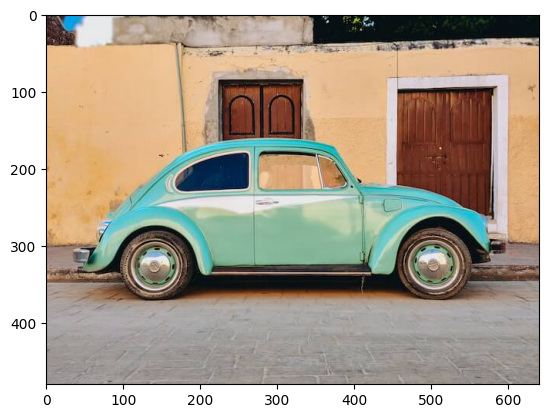

In [7]:


img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

In [8]:
outputs = generator(raw_image, points_per_batch=64)

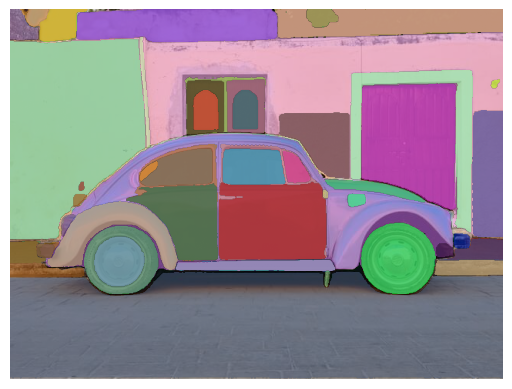

In [9]:
masks = outputs["masks"]
show_masks_on_image(raw_image, masks)

### Download test dataset

In [10]:
# https://huggingface.co/datasets/nlphuji/flickr30k
dataset = load_dataset("nlphuji/flickr30k")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset flickr30k downloaded and prepared to /root/.cache/huggingface/datasets/nlphuji___flickr30k/TEST/1.1.0/6adb9ab2367c57c3e81e76ecaecb8047ea00c33dccf9da10455037f32ec43382. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

### Example from Dataset

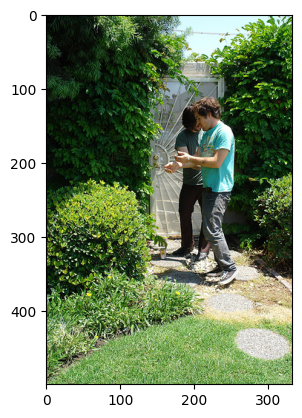

In [14]:
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
raw_image = dataset['test'][0]['image']
plt.imshow(raw_image)

In [15]:
outputs = generator(raw_image, points_per_batch=64)

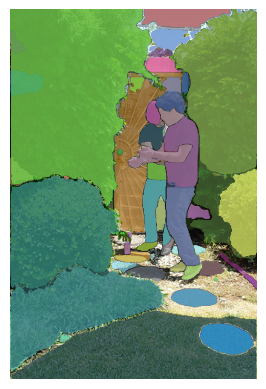

In [16]:
masks = outputs["masks"]
show_masks_on_image(raw_image, masks)

### Apply SAM to Batch

In [17]:
len(dataset['test'])

31014

In [56]:

dataset['test'][0]['image'].size

(333, 500)

In [73]:
output_df = pd.DataFrame(columns=["masks","scores", "shape"])

old = 0
for i in range(5, len(dataset['test']), 5 ):
  shapes = []
  names = []
  for c, img in enumerate(dataset['test'][old:i]['image']):
    shapes.append(img.size)
    names.append(f"image {c:03d}")

  outputs = generator(dataset['test'][old:i]['image'], points_per_batch=64)
  old = i
  batch_df = pd.DataFrame(outputs)
  batch_df['shape'] = shapes
  batch_df['image_name'] = names
  output_df = pd.concat([output_df, batch_df], axis=0)
  break # I dont want to work with all 31000 images in the toy set

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [74]:
output_df['num_components'] = output_df['masks'].apply(lambda x: len(x))
output_df['image_volume'] = output_df['shape'].apply(lambda x: x[0] * x[1])
output_df.head(3)

,masks,scores,shape,image_name,num_components,image_volume
0,"[[[False, False, False, False, False, False, F...","[tensor(1.0486), tensor(1.0277), tensor(1.0200...","(333, 500)",image 000,60,166500
1,"[[[False, False, False, False, False, False, F...","[tensor(1.0091), tensor(0.9877), tensor(0.9815...","(500, 374)",image 001,81,187000
2,"[[[False, False, False, False, False, False, F...","[tensor(1.0244), tensor(1.0195), tensor(1.0150...","(375, 500)",image 002,155,187500


In [75]:
mask_df = output_df.explode(['masks', 'scores'], ignore_index=False)
mask_df['mask_volume'] = mask_df['masks'].apply(lambda x: np.count_nonzero(x))
mask_df.head(3)

,masks,scores,shape,image_name,num_components,image_volume,mask_volume
0,"[[False, False, False, False, False, False, Fa...",tensor(1.0486),"(333, 500)",image 000,60,166500,20047
0,"[[False, False, False, False, False, False, Fa...",tensor(1.0277),"(333, 500)",image 000,60,166500,839
0,"[[True, True, True, True, True, True, True, Tr...",tensor(1.0200),"(333, 500)",image 000,60,166500,37150


Save intermediate *masks*

In [ ]:
output_df.to_excel("masks_for_each_image.xlsx")
mask_df.to_excel("each_mask_component.xlsx")

### Organize output components

In [ ]:
#TODO - save images in a way that is consistent with the image_name
  #TODO - make name each mask component? Or just keep an index going.
#TODO - get min/mean color of each component